## Setup...

In [1]:
# Various setup, probably mostly unused

from env import TestEnv
import pandas as pd
import json
import os
from conf import LisaLogging
from bart.common.Utils import area_under_curve
from trappy.plotter import plot_trace
from IPython.display import display
from trappy import ILinePlot
from trappy.stats.grammar import Parser
from bart.sched.SchedMultiAssert import SchedMultiAssert
import pandas as pd
from trace import Trace
LisaLogging.setup()
import logging
logging.getLogger('Trace').setLevel(logging.ERROR)
logging.getLogger('Analysis').setLevel(logging.WARNING)
logging.getLogger('EnergyMeter').setLevel(logging.DEBUG)
%matplotlib inline
from platforms.juno_energy import juno_energy
from platforms.pixel_energy import pixel_energy
import tests.eas.generic
from tests.eas.generic import EnergyModelTest
import numpy as np
from IPython.display import display
from wlgen import RTA, Periodic
from executor import Executor
from platforms.hikey_energy import hikey_energy
import numpy as np

2017-02-09 14:01:18,575 INFO    : root         : Using LISA logging configuration:
2017-02-09 14:01:18,576 INFO    : root         :   /home/brendan/lisa/logging.conf


In [2]:
# Disable drawing power from USB
!adb -s HT65B0300002 shell "echo 'echo 0 > /sys/class/power_supply/battery/charging_enabled' | su"

In [3]:
# Some nonsense to get caiman to work on Brendan's computer
p = os.getenv('PATH').split(':')
caiman_path = '/opt/ds5_v5.23.0/bin'
if caiman_path not in p:
    p.insert(0, caiman_path)
    os.environ['PATH'] = ':'.join(p)

In [4]:
te = TestEnv(test_conf={
        'modules': ['cgroups'], 
        'ftrace': {
            'events': ['sched_switch', 'cpu_frequency', 'cpu_idle', 'sched_load_avg_cpu', 'sched_load_avg_task', 'irq*']
        }
    }, force_new=True)

2017-02-09 14:01:18,963 INFO    : TestEnv      : Using base path: /home/brendan/lisa
2017-02-09 14:01:18,964 INFO    : TestEnv      : Loading default (file) target configuration
2017-02-09 14:01:18,964 INFO    : TestEnv      : Loading target configuration [/home/brendan/lisa/target.config]...
2017-02-09 14:01:18,966 INFO    : TestEnv      : Loading custom (inline) test configuration
2017-02-09 14:01:18,966 INFO    : TestEnv      : External tools using:
2017-02-09 14:01:18,966 INFO    : TestEnv      :    ANDROID_HOME: /home/eas/Work/Android/android-sdk-linux/
2017-02-09 14:01:18,967 INFO    : TestEnv      :    CATAPULT_HOME: /home/brendan/lisa/tools/catapult
2017-02-09 14:01:18,967 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpufreq', 'cgroups']
2017-02-09 14:01:18,967 INFO    : TestEnv      : Connecting Android target [HT65B0300002]
2017-02-09 14:01:18,968 INFO    : TestEnv      : Connection settings:
2017-02-09 14:01:18,968 INFO    : TestEnv      :    {'device': u'HT65B03

# Define Workloads
We're going to create a workload with a handful of small tasks, such that they could fit onto a single cluster at the lowest OPP. 

To avoid evertying being thrown out by the periodiciy of the tasks, the start times and periods of the tasks are staggered.

In [5]:
def get_wloads(nrg_model, cpu=0, task_pct=3):
    cpu_node = nrg_model.cpu_nodes[cpu]
    cluster_node = cpu_node.parent
    ncpus = len(cluster_node.cpus)
    min_cap = cpu_node.min_capacity
    print "min_cap {}".format(min_cap)
    task_cap = int(1024 * (task_pct / 100.))
    print "task_cap {}".format(task_cap)
    tasks_per_cpu = int(min_cap / task_cap)
    print "tasks_per_cpu {}".format(tasks_per_cpu)
    ntasks = tasks_per_cpu * ncpus
    print "total num tasks {}".format(ntasks)

    # Stagger the workloads so that they prevent shared idle states
    period_s = 5e-3
    stagger_s = 0.7e-3
    delays = np.arange(period_s, step=stagger_s)
    
    if len(delays) > ntasks:
        print "WARNING: not enough tasks to cover period with wakeups"
    
    tasks = {}
    for i in range(ntasks):
        tasks['{}pct_{}'.format(task_pct, i)] = {
            'kind': 'Periodic',
            'params': {
                'duty_cycle_pct': task_pct,
                'period_ms' : period_s * 1e3 + (i - (ntasks / 2)),
                'delay_s' : delays[i % len(delays)],
                'duration_s': 2
            }
        }
    
    wloads = {
        'anything': {
            'type': 'rt-app',
            'conf': {
                'class': 'profile',
                'params': tasks,
              #  'cpus': [1, 2, 3]
            }
        },
       # 'force_pack_silver': {
       #     'type': 'rt-app',
       #     'conf': {
       #         'class': 'profile',
       #         'params': tasks,
       #         'cpus': [0, 1]
       #     }
       # }
    }
        
    return wloads

In [6]:
wloads = get_wloads(pixel_energy)

min_cap 149
task_cap 30
tasks_per_cpu 4
total num tasks 8


# Run workloads
Now we'll run the workloads with the powersave governor

In [7]:
poor_mans_powersave = { # No powersave governor in hikey_defconfig
    'governor': 'userspace',
    'freqs':{
        0: 208000,
    }
}
powersave = {
    'governor': 'powersave'
}
performance = {
    'governor': 'performance'
}
executor = Executor(te, {
        'confs': [{
                'tag': 'myconf',
                'flags': ['ftrace'], #'freeze_userspace'],
                'cpufreq': {'governor': 'sched'}
            }],
        'wloads': wloads,
        'iterations': 30
    })

2017-02-09 14:01:23,283 INFO    : Executor     : Loading custom (inline) test configuration
2017-02-09 14:01:23,283 INFO    : Executor     : 
2017-02-09 14:01:23,284 INFO    : Executor     : ################################################################################
2017-02-09 14:01:23,284 INFO    : Executor     : Experiments configuration
2017-02-09 14:01:23,284 INFO    : Executor     : ################################################################################
2017-02-09 14:01:23,285 INFO    : Executor     : Configured to run:
2017-02-09 14:01:23,285 INFO    : Executor     :      1 target configurations:
2017-02-09 14:01:23,286 INFO    : Executor     :       myconf
2017-02-09 14:01:23,286 INFO    : Executor     :      1 workloads (30 iterations each)
2017-02-09 14:01:23,286 INFO    : Executor     :       anything
2017-02-09 14:01:23,286 INFO    : Executor     : Total: 30 experiments
2017-02-09 14:01:23,287 INFO    : Executor     : Results will be collected under:
2017-02-09

In [8]:
executor.run()

2017-02-09 14:01:24,496 INFO    : Executor     : 
2017-02-09 14:01:24,497 INFO    : Executor     : ################################################################################
2017-02-09 14:01:24,497 INFO    : Executor     : Experiments execution
2017-02-09 14:01:24,497 INFO    : Executor     : ################################################################################
2017-02-09 14:01:24,498 INFO    : Executor     : 
2017-02-09 14:01:24,498 INFO    : Executor     : ================================================================================
2017-02-09 14:01:24,498 INFO    : Executor     : configuring target for [myconf] experiments
2017-02-09 14:01:24,670 WARNING : Executor     : Setting target SELinux in permissive mode
2017-02-09 14:01:24,731 INFO    : Executor     : Configuring all CPUs to use [sched] cpufreq governor
2017-02-09 14:01:24,786 WARNING : TestEnv      : Using configuration provided RTApp calibration
2017-02-09 14:01:24,787 INFO    : TestEnv      : Using RT

# Examine Results

In [9]:
traces = [Trace(te.platform, e.out_dir, ['sched_switch', 'cpu_idle', 'cpu_frequency']) for e in executor.experiments]

## Plot task residency
It's worth visually inspecting the task residency to check that the "un-packed" runs were really unpacked and that there aren't any aliasing problems that would obviously make un-packed runs just as efficient as packed runs

In [10]:
#for trace in traces:
#    plot_trace(trace.ftrace)

In [11]:
# Plot cluster active-time. This shouldn't be needed, I used this to figure out when the 
# workload was really stressing both clusters where it wasn't packed (i.e. whether idle periods were aligned)
if False:
    for trace in traces:
        ca_signals = []
        for cluster in te.topology.get_level('cluster'):
            ca_signals.append(pd.DataFrame(trace.getClusterActiveSignal(cluster)))
        ILinePlot(ca_signals, column=0, drawstyle='steps-post', fill=True, fill_alpha=0.8).view() 
        trace.analysis.idle.plotClusterIdleStateResidency()

# Compare energy usage between packed an unpacked runs

Split up workload runs between those that were packed onto a single cluster and those that weren't. Then compare the mean energy usage for those two classes of workload runs.

In [12]:
def get_energy(experiment):
    with open(os.path.join(experiment.out_dir, 'energy.json')) as f:
        return json.load(f)['BrendanChan']

In [13]:
def get_packing_ratio(experiment, trace=None):
    if not trace:
        trace = Trace(te.platform, experiment.out_dir, ['sched_switch'])
    ma = SchedMultiAssert(trace.ftrace, te.topology, experiment.wload.tasks.keys())
    clusters_time = []
    for cluster in te.topology.get_level('cluster'):
        residencies = [t['residency'] for p, t in ma.getResidency('cluster', cluster).iteritems()]
        clusters_time.append(sum(residencies))
    total_time = sum(clusters_time)
    cluster_props = [c / total_time for c in clusters_time]
    return max(cluster_props) - min(cluster_props)

In [14]:
def get_energy_samples_acme(experiment):
    csv_path = os.path.join(experiment.out_dir, 'samples_BrendanChan.csv')
    samples_df = pd.read_csv(csv_path, sep=", ", engine='python', index_col='"timestamp ms"')
    samples_df.index.name='time'
    samples_df.index /= 1000 # 'time' field of ACME CSV is in ms. Convert to s.
    samples_df = samples_df[['"power mW"']]
    samples_df.columns = ['power']
    return samples_df

In [15]:
results = []
for experiment, trace in zip(executor.experiments, traces):
    results.append({
            'pack_ratio': get_packing_ratio(experiment, trace),
            'energy': get_energy(experiment)
    })
df = pd.DataFrame(results, columns=['pack_ratio', 'energy'])
df.corr()

,pack_ratio,energy
pack_ratio,1.000000,-0.358937
energy,-0.358937,1.000000


In [16]:
df

,pack_ratio,energy
0,0.995159,671.05
1,0.089430,1550.66
2,0.287097,667.98
3,0.944405,756.80
4,0.586566,824.34
5,0.477835,766.67
6,1.000000,675.00
7,0.704787,730.26
8,0.561235,634.21
9,0.192394,662.50


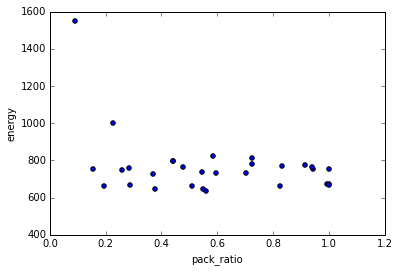

In [17]:
df.plot(kind='scatter', x='pack_ratio', y='energy')

In [18]:
wload_nrgs = {}
for experiment, trace in zip(executor.experiments, traces):
    name = experiment.wload.name
    if name not in wload_nrgs:
        wload_nrgs[name] = []
    wload_nrgs[name].append(get_energy(experiment))

for name, nrgs in wload_nrgs.iteritems():
    print "Wload {:<20s} mean energy: {:02f}".format(name, np.mean(nrgs))

Wload anything             mean energy: 764.590333


In [19]:
def examine_experiment(experiment):
    trace = Trace(te.platform, experiment.out_dir, ['sched_switch'])
    ma = SchedMultiAssert(trace.ftrace, te.topology, experiment.wload.tasks.keys())
    cluster_conclusions = []
    for cluster in te.topology.get_level('cluster'):
        residencies = [t['residency'] for p, t in ma.getResidency('cluster', cluster, percent=True).iteritems()]
        if all(r > 90 for r in residencies):
            cluster_conclusions.append('PACKED')
        else:
            cluster_conclusions.append(None)
    packed = [i for i, c in enumerate(cluster_conclusions) if c == 'PACKED']
    energy = get_energy(experiment)
    if not packed:
        print "I don't think we packed onto any cluster"
        return False, energy
        # plot_trace(trace.ftrace)
    elif len(packed) == 1:
        [i] = packed
        print 'I think we packed onto cluster {} ({})'.format(i, te.topology.get_node('cluster', i))
        return True, energy
    else:
        raise Exception('i am borken')

In [20]:
previous_energy_records = [[], []] # Use this to store old results

In [21]:
energy_records = previous_energy_records
for experiment in executor.experiments:
    packed, energy = examine_experiment(experiment)
    energy_records[packed].append(energy)

I think we packed onto cluster 0 ([0, 1])
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I think we packed onto cluster 0 ([0, 1])
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I think we packed onto cluster 0 ([0, 1])
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I think we packed onto cluster 0 ([0, 1])
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't thin

In [22]:
unpacked_nrg, packed_nrg = [np.mean(n) for n in energy_records]
print 'Average energy when not packed: {}'.format(unpacked_nrg)
print 'Average energy when packed: {}'.format(packed_nrg)

print 'Improvement by packing: {:02f}%'.format(((unpacked_nrg - packed_nrg) / unpacked_nrg) * 100)

Average energy when not packed: 775.809615385
Average energy when packed: 691.665
Improvement by packing: 10.846039%


In [23]:
energy_records

[[1550.66,
  667.98,
  756.8,
  824.34,
  766.67,
  730.26,
  634.21,
  662.5,
  754.39,
  777.19,
  763.16,
  768.64,
  734.43,
  758.11,
  780.92,
  797.59,
  665.35,
  735.53,
  999.34,
  663.16,
  749.34,
  798.25,
  810.75,
  648.46,
  726.97,
  646.05],
 [671.05, 675.0, 751.75, 668.86]]

For standard 1.2 kernel: 8x3pct tasks w/ phase/period wangjanglement + `freeze_userspace`:
```
Average energy when not packed: 606.440625
Average energy when packed: 617.63375
Improvement by packing: -1.845708%
```